# Scaler dataframe for Auger Open Data 
## A Neutron Monitor Comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import augerscalerpy.plot_config as pc
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data ## ESTA SÍ ESSSSS LA FORMAAAAAAAAAAA!!!!!!!!


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Bases de datos disponibles

#### https://www.nmdb.eu/nest/
#### https://cidas.isee.nagoya-u.ac.jp/WDCCR/station_list.php
#### Las páginas oficiales de las estaciones: http://cr0.izmiran.ru/common/
#### El servicio de IZMIRAN http://cr0.izmiran.ru/rome/main.htm

Fuentes de datos oficiales con los datos corregidos:
#### México: http://www.cosmicrays.unam.mx/
#### Oulu: https://cosmicrays.oulu.fi/
#### Rome: Revisar este --> http://webusers.fis.uniroma3.it/svirco/pag_2.html


# DATOS DE NMDB: the Neutron Monitor Database
## Real-Time Database for high-resolution Neutron Monitor measurements

Trabajo con datos de algunas estaciones directamente.

### DATASETS DE LA NMDB:

In [2]:
skip_rows = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,22,23] # Filas de los datos de NMDB que deben ser ignorados

In [9]:
def nmdb_clean(filename):
    skip_rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23]
    df = pd.read_csv(filename, delimiter=';', skiprows=skip_rows, header=None)
    df.columns = ['date', 'counts/s']
    df['date'] = pd.to_datetime(df['date'])
    df['counts/s'] = df['counts/s'].astype('float64')
    columnas_numericas = df.columns[df.dtypes == 'float64']
    promedios_df = df[columnas_numericas].mean()
    df[columnas_numericas] = df[columnas_numericas] / promedios_df
    ################################## ELIMINANDO LOS EXCESOS
    # Define la columna objetivo
    column_name = "counts/s"
    mean = df[column_name].mean()
    # Define un factor para determinar los valores que considerarás excesos
    threshold = 0.2  # 20% por fuera de la media
    # Reemplaza los valores que están por fuera del umbral por el valor medio
    df[column_name] = np.where(abs(df[column_name] - mean) > threshold * mean, mean, df[column_name])
    # Grafica el resultado
    #df.plot(kind='scatter', s=2, x='date', y='counts/s', figsize=(10, 5), color='black')
    return df

In [3]:
athenas = nmdb_clean('nm_data/long_files/athenas_NMDB.txt')
oulu = nmdb_clean('nm_data/long_files/Oulu_NMDB.txt')
mexico = nmdb_clean('nm_data/long_files/mexico_NMDB.txt')
roma = nmdb_clean('nm_data/long_files/rome_NMDB.txt')
tsumeb = nmdb_clean('nm_data/long_files/tsumeb_NMDB.txt')

### Importando datos del dataframe final creado
##### 'CRI_auger_NM_3H.csv'

In [6]:
combined_df = pd.read_csv('nm_data/CRI_auger_NM_3H.csv')
#combined_df.set_index('date', inplace=True) # Convierto la columna Date en índices esto los preserva
#combined_df = combined_df.astype(float)
combined_df

,date,oulu,auger,mexico,athenas,roma,tsumeb
0,1990-01-01 00:00:00+00:00,0.835339,NaN,0.934069,NaN,NaN,NaN
1,1990-01-01 03:00:00+00:00,0.836135,NaN,0.936287,NaN,NaN,0.926468
2,1990-01-01 06:00:00+00:00,0.840431,NaN,0.934765,NaN,NaN,0.926723
3,1990-01-01 09:00:00+00:00,0.839158,NaN,0.933133,NaN,NaN,0.925214
4,1990-01-01 12:00:00+00:00,0.839635,NaN,0.937709,NaN,NaN,0.926668
...,...,...,...,...,...,...,...
93491,2021-12-30 09:00:00+00:00,1.064302,1.003458,1.037700,1.015503,1.0,1.000000
93492,2021-12-30 12:00:00+00:00,1.065415,1.003458,1.041967,1.015449,1.0,1.000000
93493,2021-12-30 15:00:00+00:00,1.060005,1.003458,1.041962,1.011533,1.0,1.000000
93494,2021-12-30 18:00:00+00:00,1.053164,1.003458,1.041494,1.009747,1.0,1.000000


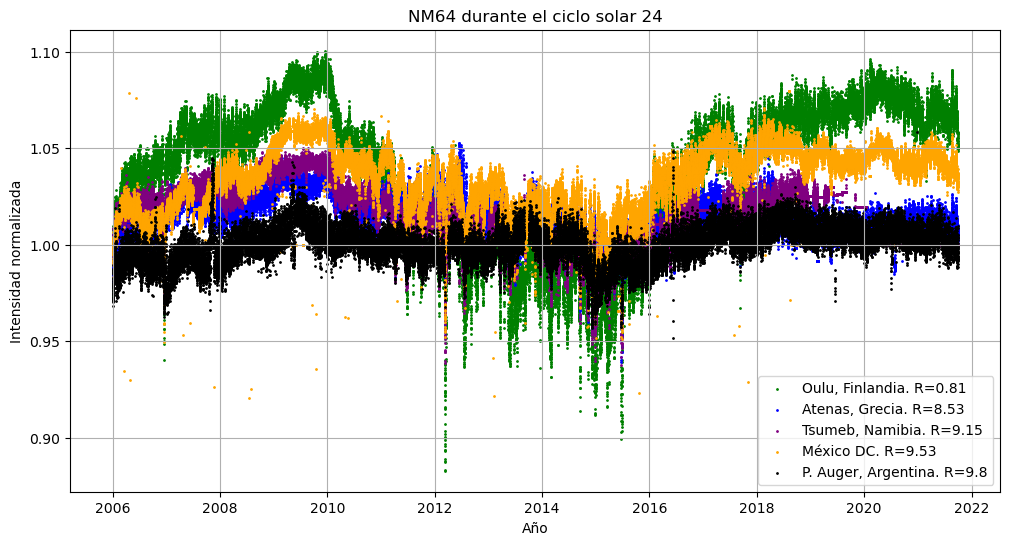

In [7]:
# Asegura que 'date' esté en formato de fecha
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Filtrar los datos para el rango de años de enero de 2006 a septiembre de 2021
start_date = '2006-01-01'
end_date = '2021-09-30'
filtered_df = combined_df[(combined_df['date'] >= start_date) & (combined_df['date'] <= end_date)]

# Establecer 'date' como índice y seleccionar las columnas de ubicaciones
locations = ['oulu', 'athenas', 'tsumeb', 'mexico', 'auger']
filtered_df.set_index('date', inplace=True)
filtered_df = filtered_df[locations]

plt.figure(figsize=(12, 6))
#
for location in locations:
    label = {
        'oulu': 'Oulu, Finlandia. R=0.81',
        'athenas': 'Atenas, Grecia. R=8.53',
        'tsumeb': 'Tsumeb, Namibia. R=9.15',
        'mexico': 'México DC. R=9.53',
        'auger': 'P. Auger, Argentina. R=9.8'
    }[location]
    
    color = {
        'oulu': 'green',
        'athenas': 'blue',
        'tsumeb': 'purple',
        'mexico': 'orange',
        'auger': 'black'
    }[location]
    
    marker = 'o'  # Cambia el marcador si es necesario
    plt.scatter(filtered_df.index, filtered_df[location], label=label, color=color, marker=marker, s=1)

# Crear una leyenda personalizada con marcadores más grandes
legend = plt.legend(fontsize=12)
for handle in legend.legendHandles:
    handle.set_sizes([50])  # Ajustar el tamaño de los marcadores en la leyenda
#
#for location in locations:
#    plt.scatter(filtered_df.index, filtered_df[location], label=f'{location.capitalize()}', s=1)

plt.xlabel('Año')
plt.ylabel('Intensidad normalizada')
plt.title('NM64 durante el ciclo solar 24')
plt.legend()
plt.grid()
plt.show()


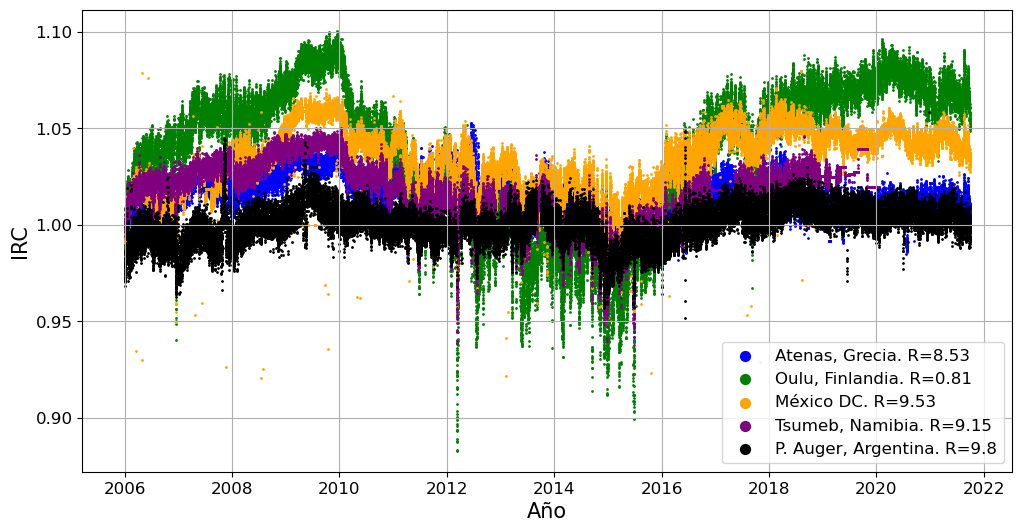

In [10]:
import matplotlib.pyplot as plt

athenas = filtered_df['athenas']
oulu = filtered_df['oulu']
# roma = combined_df['counts/s_3']
mexico = filtered_df['mexico']
tsumeb = filtered_df['tsumeb']
auger = filtered_df['auger']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53', marker='o', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81', marker='o', s=1)
# plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53', marker='o', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15', marker='o', s=1)
plt.scatter(auger.index, auger, color='black', label='P. Auger, Argentina. R=9.8', marker='o', s=1)

plt.xlabel('Año', fontsize=15)
plt.ylabel('IRC', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('')

# Crear una leyenda personalizada con marcadores más grandes
legend = plt.legend(fontsize=12)
for handle in legend.legendHandles:
    handle.set_sizes([50])  # Ajustar el tamaño de los marcadores en la leyenda

plt.grid()
plt.savefig('NM_Auger_comparison.pdf', dpi=300)
plt.savefig('NM_Auger_comparison.png')
plt.show()